# Life-Cycle Savings Model

## Environment

Time is discrete and indexed by $t$. Individuals live for a finite number of periods, $T$. They derive utility from consumption according to a CRRA utility function: 

$$ u(c) = \frac{c^{1-\sigma}}{1-\sigma} $$

and from "bequests", which are modeled here as cash on hand net of consumption in the final period:

$$ \nu(a) = \psi \frac{a^{1-\sigma}}{1-\sigma} $$.

Consumption can be transferred between periods via a portfolio of one-period bonds ("savings', $a$) that can be purchased at the price $1 / (1+r)$, and there is no borrowing. Inviduals receive income $y$ every period that is governed by a deterministic ($\mu_{t}$) and stochastic component:

$$ \log(y_{t}) = \mu_{t} + \varepsilon_{it} $$

where $\varepsilon_{it}$ is a stationary AR 1 process:

$$ \varepsilon_{it} = \rho \varepsilon_{it-1} + \eta_{it} $$

where $\eta_{it} \sim \mathcal{N}(0,\sigma^2_{\eta})$. The unconditional variance of $\varepsilon_{it}$ is therefore $\sigma^2_{\eta} / (1-\rho^2)$.

## Model Solution

Define

$$ V_{T}(a,\varepsilon) = \max_{c}\left\{u(c) + \nu(y - c)\right\} $$

And now define the remaining value functions recursively:

$$ V_{t}(a,\varepsilon) = \max_{c,a'}\left\{u(c) + \beta\mathbb{E}_{\varepsilon'|\varepsilon}V(a',\varepsilon')\right\} $$

subject to:

$$ c + \frac{1}{1+r}a' \leq y + a $$

and 

$$ a' \geq 0$$

We're going to write code to solve the model naively using this recursive formulation. You may already be aware that there are more efficient solution methods that exploit the first order conditions of the problem. Not the focus of our class! Please don't use the example below as a demonstration of best practice when it comes to solving savings models.

We'll start picking some default parameters.

In [126]:
pars = (;
    T = 45, β = 0.95, σ = 2,ρ = 0.9,ση = 0.1, μ = fill(2.,45), ψ = 5., r = 0.05
)

(T = 45, β = 0.95, σ = 2, ρ = 0.9, ση = 0.1, μ = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], ψ = 5.0, r = 0.05)

Next we'll write a function that uses Tauchen's method to approximate the income process as a discrete markov process.

In [12]:
using Distributions,Random
using LinearAlgebra
Φ(x) = cdf(Normal(),x)

function tauchen(ρ,ση,Kϵ)
    sd = ση/sqrt(1-ρ^2)
    grid = range(-3sd,stop=3sd,length=Kϵ)
    Π = zeros(Kϵ,Kϵ)
    Δ = grid[2]-grid[1]
    for j=1:Kϵ
        Π[1,j] = Φ((grid[1] + Δ/2 - ρ*grid[j])/ση)
        Π[end,j] = 1 - Φ((grid[end] - Δ/2 - ρ*grid[j])/ση)
        for k=2:(Kϵ-1)
            Π[k,j] = Φ((grid[k] + Δ/2 - ρ*grid[j])/ση) - Φ((grid[k] - Δ/2 - ρ*grid[j])/ση)
        end
    end
    return Π,grid
end


tauchen (generic function with 1 method)

Now, let's think about how to solve this model. We have two state variables to track. We have discretized $\varepsilon$, now let's discretize assets and define a max operator.

In [127]:
Ka = 100
Kϵ = 5
agrid = LinRange(0,pars.μ[1] * pars.T,Ka) #<- is this a reasonable upper bound? We'll find out!
Π,ϵgrid = tauchen(pars.ρ,pars.ση,Kϵ)
pars = (;pars...,Ka,agrid,Π,ϵgrid,Kϵ)

u(c,σ) = c^(1-σ) / (1-σ)

function solve_max(V,t,iϵ,ia,pars)
    (;agrid,ϵgrid,Π,σ,Ka,r,β) = pars
    cash = exp(pars.μ[t] + ϵgrid[iϵ]) + agrid[ia]
    amax = 0
    vmax = -Inf
    loop = true
    a = 1
    while loop && a<Ka
        c = cash - agrid[a] / (1+r)
        if c>0
            #@views v = u(c,σ) + β * dot(Π[:,iϵ],V[:,a,t+1])
            v = u(c,σ)
            for iϵ′ in axes(V,1)
                v += β * Π[iϵ′,iϵ] * V[iϵ′,a,t+1]
            end
            if v>vmax
                vmax = v
                amax = a
            end
        else
            loop = false
        end
        a += 1 #<- move one up the grid space
    end
    return amax,vmax
end

solve_max (generic function with 1 method)

Next, a function that uses this max operator to get the value function for all states in a period, $t$, and records the optimal savings policy.

In [118]:
function iterate!(V,A,t,pars)
    for ia in axes(V,2), iϵ in axes(V,1)
        A[iϵ,ia,t],V[iϵ,ia,t] = solve_max(V,t,iϵ,ia,pars)
    end
end
function terminal_values!(V,pars)
    (;σ,ψ,agrid) = pars
    for ia in axes(V,2), iϵ in axes(V,1)
        V[iϵ,ia] = ψ * u(agrid[ia],σ)
    end
end


terminal_values! (generic function with 2 methods)

In [89]:
function backward_induction!(V,A,pars)
    (;ψ,σ,T,agrid) = pars
    # set the values at T+1 (bequest motives)
    @views terminal_values!(V[:,:,T+1],pars)
    for t in reverse(1:T)
        iterate!(V,A,t,pars)
    end
end

backward_induction! (generic function with 1 method)

Let's check the model solution and time it also.

In [128]:
V = zeros(pars.Kϵ,pars.Ka,pars.T+1)
A = zeros(Int64,pars.Kϵ,pars.Ka,pars.T)
backward_induction!(V,A,pars)
@time backward_induction!(V,A,pars)


  0.010476 seconds


Seems ok. We can plot the policy functions as a sanity check. The plot below shows savings policy at the median wage shock over time at different levels of assets.

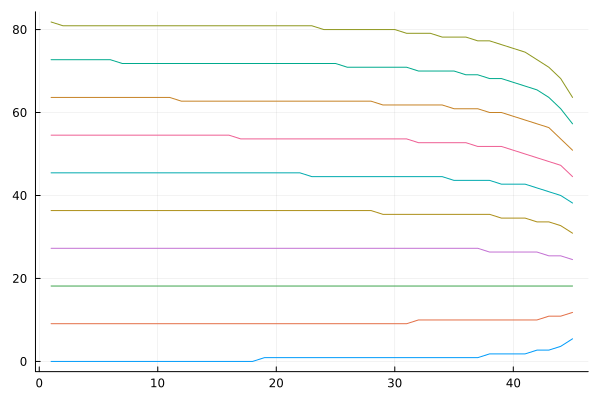

In [135]:
using Plots

plot(1:pars.T,agrid[A[3,1:10:Ka,:]'],legend=false)



You can see that the discreteness creates some jumpiness in the policy functions. As I said, other solution methods that use interpolation can be more efficient and will create smoother pictures, but since that is not the focus of this class we will use this simple solution method.